# Slot-Based Mixture Modeling

How to model mixtures with a slot-based approach instead of the traditional approach.

Find more information here:
- [Mixture Example](https://emdgroup.github.io/baybe/examples/Constraints_Discrete/mixture_constraints.html)
- [BayBE GitHub](https://github.com/emdgroup/baybe)
- [BayBE Userguide](https://emdgroup.github.io/baybe/userguide/userguide.html)

<a target="_blank" href="https://colab.research.google.com/github/emdgroup/baybe-ac24-workshop/blob/main/3_Slot_Based_Mixtures.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://mybinder.org/v2/gh/emdgroup/baybe-ac24-workshop/HEAD?labpath=3_Slot_Based_Mixtures.ipynb">
  <img src="https://mybinder.org/badge_logo.svg" alt="Launch Binder"/>
</a>

# Install and Import

In [ ]:
!pip install 'baybe[chem]==0.10.0' seaborn matplotlib

In [ ]:
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', message = '.*BayBE.*')

import baybe
os.environ['BAYBE_CACHE_DIR']='' # turn descriptor caching off
baybe.__version__

# Defining Mixture Substances

Let us consider 6 common solvents and create an experimental campaign supposed to optimize their mixture.

In [22]:
dict_solvents = {
    "Water": "O",
    "Hexane": "CCCCCC",
    "Toluene": "CC1=CC=CC=C1",
    "DMF": "CN(C)C=O",
    "Dioxane": "C1COCCO1",
    "Ethanol":"CCO",
}

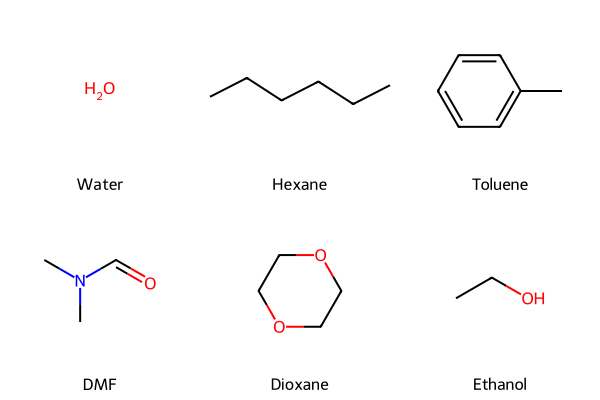

In [23]:
from rdkit import Chem
from rdkit.Chem import Draw

mols = [Chem.MolFromSmiles(smi) for smi in dict_solvents.values()]
Draw.MolsToGridImage(mols, molsPerRow = 3, legends = dict_solvents.keys())

# Traditional Mixture Search Space

In this example we use discrete setpoints for the concentrations.

In [4]:
setpoints = np.linspace(0.0, 1.0, 10+1).round(2).tolist()
setpoints

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

Now we create a numerical parameter for each of the substances.

In [5]:
from baybe.parameters import NumericalDiscreteParameter

parameters = [
    NumericalDiscreteParameter(
        name=f'{name}',
        values=setpoints
    )
    for name in dict_solvents
]

## Inspecting SearchSpaces

In BayBE, a search space is represented by a `discrete` and `continuous` part. These sub spaces manage all aspects dealing with translating the users-defined settings to something machine readable for the machine learning surrogate mdoel.

The `discrete` sub space has two dataframes representing all desired combinations resulting from discrete parameters.
- `exp_rep`: The experimental representation, still containing labels for e.g. categories and substances. Recommendations given to the user will be in this representation.
- `comp_rep`: The comutational representation, consisting of only numbers that result from the encoding of parameter labels and values.

You can access the underlying data frames like `searchspace.discrete.exp_rep` and `searchspace.discrete.comp_rep`.

## SearchSpace Via Constraint

In this notebook we will limit us to create the correpsonding search space with discrete parameters, i.e. with concrete set points. But the traditional mixture representation in BayBE can also be achieved with continuous numerical parameters and corresponding linear equality constarints.

In [26]:
from baybe.constraints import DiscreteSumConstraint, ThresholdCondition
from baybe.searchspace import SearchSpace

sum_constraint = DiscreteSumConstraint(parameters = dict_solvents.keys(),
                                       condition = ThresholdCondition(threshold = 1.0,
                                                                      operator = '='))

searchspace = SearchSpace.from_product(parameters = parameters,
                                       constraints = [sum_constraint])
searchspace.discrete.exp_rep

,Water,Hexane,Toluene,DMF,Dioxane,Ethanol
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.1,0.9
2,0.0,0.0,0.0,0.0,0.2,0.8
3,0.0,0.0,0.0,0.0,0.3,0.7
4,0.0,0.0,0.0,0.0,0.4,0.6
...,...,...,...,...,...,...
2998,0.0,0.0,0.9,0.0,0.1,0.0
2999,0.0,0.0,0.9,0.1,0.0,0.0
3000,0.1,0.0,0.9,0.0,0.0,0.0
3001,0.0,0.1,0.9,0.0,0.0,0.0


In [27]:
# Check that all rows sum to 1.0 (within a small tolerance)
(searchspace.discrete
            .exp_rep
            .sum(axis = 1)
            .apply(lambda x: x-1.0)
            .abs()
            .lt(0.001)
            .all())

True

## SearchSpace Via Simplex Constructor
This constructor already incorporates the main sum constraint during the product creation and hence is much more efficient. It is always to be preferred for discrete mixture representations. This constructor, for isntance, also has the capability to include cardinality constraints (also known as n-choose-k or similar), which is useful when e.g. a minimum of `k1` and a maximum of `k2` components should be included in the mixture (`min_nonzero` and `max_nonzero` arguments, not used below).

More details on the simplex constructor [here](https://emdgroup.github.io/baybe/userguide/searchspace.html#creating-a-simplex-bound-discrete-subspace) and [here](https://emdgroup.github.io/baybe/_autosummary/baybe.searchspace.discrete.SubspaceDiscrete.html#baybe.searchspace.discrete.SubspaceDiscrete.from_simplex).

In [8]:
from baybe.searchspace import SubspaceDiscrete

discrete_space2 = SubspaceDiscrete.from_simplex(1.0, # Overall sum we intend
                                                parameters, # Our numerical parameters
                                                product_parameters = None, # We have no other parameters
                                                constraints = None, # We have no other constraints
                                                boundary_only = True) # We only want entries on the bpundary of 1.0, not below
searchspace2 = SearchSpace(discrete = discrete_space2)
searchspace2.discrete.exp_rep

,Water,Hexane,Toluene,DMF,Dioxane,Ethanol
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.1,0.9
2,0.0,0.0,0.0,0.0,0.2,0.8
3,0.0,0.0,0.0,0.0,0.3,0.7
4,0.0,0.0,0.0,0.0,0.4,0.6
...,...,...,...,...,...,...
2998,0.9,0.0,0.0,0.0,0.1,0.0
2999,0.9,0.0,0.0,0.1,0.0,0.0
3000,0.9,0.0,0.1,0.0,0.0,0.0
3001,0.9,0.1,0.0,0.0,0.0,0.0


In [9]:
# Check that all rows sum to 1.0 (within a small tolerance)
(searchspace2.discrete
             .exp_rep
             .sum(axis = 1)
             .apply(lambda x: x-1.0)
             .abs()
             .lt(0.001)
             .all())

True

# Slot-Based Search Space

Instead of one parameter per allowed substance, we will create slots. Each slot is represented by two parameters, one for the label of the substance that is in the slot, and another one for the concentration associated with that slot.

To do this we must choose the maximum number of slots. This means we model a mixture that allows "up to `N_SLOTS` substances" being part of it. This comes with two distinct advantages:
- We can use BayBE's label encoding to inform the model about the chemical properties of the substances in the slot
- Since without additional constraints, slots are numered and thus imply an order, this automatically models the order of addition, too

In [28]:
from baybe.parameters import SubstanceParameter

N_SLOTS = 3

# Parameters fore the slot labels
slots = [
    SubstanceParameter(name = f'Slot_{k+1}', data = dict_solvents)
    for k in range(N_SLOTS)
]

# Parameters for the slot concentrations
slot_amounts = [
    NumericalDiscreteParameter(name = f'Slot_{k+1}_Amount', values = setpoints)
    for k in range(N_SLOTS)
]

# We also need a sum constraint for the overal sum
sum_constraint = DiscreteSumConstraint(
    parameters = [p.name for p in slot_amounts],
    condition = ThresholdCondition(
        threshold = 1.0,
        operator = '='
    )
)

## Naive Result
Without further consideration we get a search space that has several issues that need to be fixed, some of them not so obvious. 

In [11]:
searchspace3a = SearchSpace.from_product(
    parameters = slots + slot_amounts,
    constraints = [sum_constraint]
)

searchspace3a.discrete.exp_rep

,Slot_1,Slot_2,Slot_3,Slot_1_Amount,Slot_2_Amount,Slot_3_Amount
0,Water,Water,Water,0.0,0.0,1.0
1,Water,Water,Water,0.0,0.1,0.9
2,Water,Water,Water,0.0,0.2,0.8
3,Water,Water,Water,0.0,0.3,0.7
4,Water,Water,Water,0.0,0.4,0.6
...,...,...,...,...,...,...
14251,Ethanol,Ethanol,Ethanol,0.8,0.1,0.1
14252,Ethanol,Ethanol,Ethanol,0.8,0.2,0.0
14253,Ethanol,Ethanol,Ethanol,0.9,0.0,0.1
14254,Ethanol,Ethanol,Ethanol,0.9,0.1,0.0


## Avoid Duplicate Slots - `DiscreteNoLabelDuplicatesConstraint`

In [29]:
from baybe.constraints import DiscreteNoLabelDuplicatesConstraint

no_label_duplicate_constraint = DiscreteNoLabelDuplicatesConstraint(
    parameters = [p.name for p in slots]
)

searchspace3b = SearchSpace.from_product(
    parameters = slots + slot_amounts,
    constraints = [sum_constraint,
                   no_label_duplicate_constraint])

searchspace3b.discrete.exp_rep

,Slot_1,Slot_2,Slot_3,Slot_1_Amount,Slot_2_Amount,Slot_3_Amount
0,Toluene,Hexane,Water,0.0,0.0,1.0
1,Toluene,Hexane,Water,0.0,0.1,0.9
2,Toluene,Hexane,Water,0.0,0.2,0.8
3,Toluene,Hexane,Water,0.0,0.3,0.7
4,Toluene,Hexane,Water,0.0,0.4,0.6
...,...,...,...,...,...,...
7915,DMF,Dioxane,Ethanol,0.8,0.1,0.1
7916,DMF,Dioxane,Ethanol,0.8,0.2,0.0
7917,DMF,Dioxane,Ethanol,0.9,0.0,0.1
7918,DMF,Dioxane,Ethanol,0.9,0.1,0.0


## Avoid Degenerate Points Caused by a Dependency - `DiscreteDependenciesConstraint`

By "dependency" we mean a situation where the values of a parameter only matter if another parameter has a certain value.

This is, for instance, the case in our slot-based mixture approach, because the slot label does not matter if the slot amount is 0.

Another example for this is a switch that turns on certain parts of the equipment which have their own settings. However, these settings only matter if the switch is actually 'on'. If not, these settings can take any value without affecting the result.

In [30]:
def show_degenerate_points(df, point):
    """Returns degenerate equivalents of `point` that are found in `df`.
    
    This assumes that 0.0 is the degeneracy-causing value on the amounts.
    """
    
    idxs = []
    for ind, row in df.iterrows():
        mask = (row['Slot_1_Amount'] == 0.0) or (row['Slot_1'] == point['Slot_1'].values[0])
        mask &= (row['Slot_2_Amount'] == 0.0) or (row['Slot_2'] == point['Slot_2'].values[0])
        mask &= (row['Slot_3_Amount'] == 0.0) or (row['Slot_3'] == point['Slot_3'].values[0])
        mask &= row['Slot_1_Amount'] == point['Slot_1_Amount'].values[0]
        mask &= row['Slot_2_Amount'] == point['Slot_2_Amount'].values[0]
        mask &= row['Slot_3_Amount'] == point['Slot_3_Amount'].values[0]
        if mask:
            idxs.append(ind)

    return df.loc[idxs]

Lets take a look at the degenerate equivalents of the first search space entry. (if you pick en entry that has no 0.0 in the amounts, no degenerate points are expected).

In [33]:
show_degenerate_points(df = searchspace3b.discrete.exp_rep,
                       point = searchspace3b.discrete.exp_rep.iloc[[1]])

,Slot_1,Slot_2,Slot_3,Slot_1_Amount,Slot_2_Amount,Slot_3_Amount
1,Toluene,Hexane,Water,0.0,0.1,0.9
67,DMF,Hexane,Water,0.0,0.1,0.9
133,Dioxane,Hexane,Water,0.0,0.1,0.9
199,Ethanol,Hexane,Water,0.0,0.1,0.9


In [34]:
from baybe.constraints import DiscreteDependenciesConstraint

dependency_constraint = DiscreteDependenciesConstraint(
    parameters = ["Slot_1_Amount",
                  "Slot_2_Amount",
                  "Slot_3_Amount"],
    affected_parameters = [["Slot_1"], # depends on Slot_1_Amount being > 0.0
                           ["Slot_2"], # depends on Slot_2_Amount being > 0.0
                           ["Slot_3"]],# depends on Slot_3_Amount being > 0.0
    conditions = [
        ThresholdCondition(threshold = 0.0, operator = ">"), # the affected parameters are only relevant is this condition is True
        ThresholdCondition(threshold = 0.0, operator = ">"),
        ThresholdCondition(threshold = 0.0, operator = ">"),
    ],
)

searchspace3c = SearchSpace.from_product(parameters = slots + slot_amounts,
                                         constraints = [sum_constraint,
                                                        no_label_duplicate_constraint,
                                                        dependency_constraint])

Lets check again whether there are any degenerate points left after including the constraint. There should be none.

In [36]:
show_degenerate_points(df = searchspace3c.discrete.exp_rep, 
                       point = searchspace3c.discrete.exp_rep.iloc[[1]])

,Slot_1,Slot_2,Slot_3,Slot_1_Amount,Slot_2_Amount,Slot_3_Amount
1,Toluene,Hexane,Water,0.0,0.1,0.9


## Avoid Permutation Duplicates - `DiscretePermutationInvarianceConstraint`

Since the slots are numbered you can see that as natural order of addition. In that case there is no permutation invariance. But if the order does not matter we need to remove permutation invariant search space entries.

In [38]:
from itertools import permutations

def show_permutation_equivalent_points(df, point):
    """Returns permutation equivalents of `point` that are found in `df`."""
    
    slot_cols = ['Slot_1','Slot_2','Slot_3']
    amount_cols = ['Slot_1_Amount','Slot_2_Amount','Slot_3_Amount']
    
    idxs = []
    for perm in permutations([0,1,2]):
        slots_permuted = [slot_cols[k] for k in perm]
        amount_permuted = [amount_cols[k] for k in perm]
        mask = (df[slot_cols].values == point[slots_permuted].values).all(axis=1)
        mask &= (df[amount_cols].values == point[amount_permuted].values).all(axis=1)
        idxs += df.index[mask].to_list()
    
    return df.loc[idxs]

Lets check out the permutaiton-equivalent points of a random entry.

In [39]:
show_permutation_equivalent_points(df = searchspace3c.discrete.exp_rep,
                                   point = searchspace3c.discrete.exp_rep.sample(1))

,Slot_1,Slot_2,Slot_3,Slot_1_Amount,Slot_2_Amount,Slot_3_Amount
3712,Ethanol,Water,Dioxane,0.7,0.2,0.1
805,Ethanol,Dioxane,Water,0.7,0.1,0.2
4207,Water,Ethanol,Dioxane,0.2,0.7,0.1
5012,Water,Dioxane,Ethanol,0.2,0.1,0.7
962,Dioxane,Ethanol,Water,0.1,0.7,0.2
4484,Dioxane,Water,Ethanol,0.1,0.2,0.7


All of these points are equivalent. 
All except 1 must be removed from the searchspace.
This is what `DiscretePermutationInvarianceConstraint` does.

In [40]:
from baybe.constraints import DiscretePermutationInvarianceConstraint

perm_inv_constraint = DiscretePermutationInvarianceConstraint(
    parameters = [p.name for p in slots],
    dependencies = dependency_constraint
)

searchspace3d = SearchSpace.from_product(parameters = slots + slot_amounts,
                                         constraints = [sum_constraint,
                                                        no_label_duplicate_constraint,
                                                        perm_inv_constraint])

Lets re-check whether there are any permutaiton-invariant entries left.

In [20]:
show_permutation_equivalent_points(df = searchspace3d.discrete.exp_rep,
                                   point = searchspace3d.discrete.exp_rep.sample(1))

,Slot_1,Slot_2,Slot_3,Slot_1_Amount,Slot_2_Amount,Slot_3_Amount
30,Toluene,Hexane,Water,0.3,0.0,0.7


## A Look at the Final Search Space

It is much smaller than the original one that did not consider the various invariances.

In [41]:
searchspace3d.discrete.exp_rep

,Slot_1,Slot_2,Slot_3,Slot_1_Amount,Slot_2_Amount,Slot_3_Amount
0,Toluene,Hexane,Water,0.0,0.0,1.0
1,Toluene,Hexane,Water,0.0,0.1,0.9
2,Toluene,Hexane,Water,0.0,0.2,0.8
3,Toluene,Hexane,Water,0.0,0.3,0.7
4,Toluene,Hexane,Water,0.0,0.4,0.6
...,...,...,...,...,...,...
856,Ethanol,Dioxane,DMF,0.6,0.2,0.2
857,Ethanol,Dioxane,DMF,0.6,0.3,0.1
858,Ethanol,Dioxane,DMF,0.7,0.1,0.2
859,Ethanol,Dioxane,DMF,0.7,0.2,0.1


# In Progress: Bringing it All Togehter

To model slot-based mixtures we will soon provide a custom constructor. This will take care of creation the necessary constraints automatically
```python
discrete_subspace = SubspaceDiscrete.from_slot_based_mixture(
    slots, # parameters that can be arbitrarily encoded
    setpoints,
    permutation_invariant = True # when order of addition does not matter
)
```

(not yet executable)